In [ ]:
#%%

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

# Load pretrained ResNet18
pretrained_resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers (optional)
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Replace classifier head for CIFAR-10 (10 classes)
num_features = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(num_features, 10)

In [ ]:
# %%

# Fine-Tune ResNet18 on CIFAR-10
# Same setup as before:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize RGB channels
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# %%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_resnet = pretrained_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_resnet.fc.parameters(), lr=0.001)  # Only train new head

# Training loop (same as before)
for epoch in range(5):
    pretrained_resnet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 1.7272
Epoch 2, Loss: 1.5995
Epoch 3, Loss: 1.5807
Epoch 4, Loss: 1.5697
Epoch 5, Loss: 1.5663


In [ ]:
#%%

# testing model performance
pretrained_resnet.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 44.67%


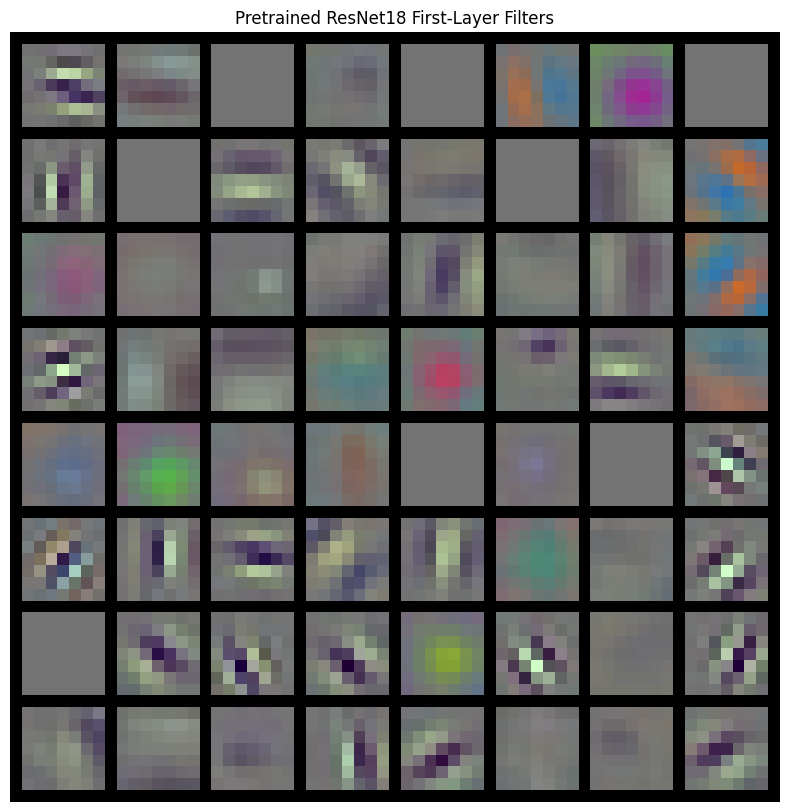

In [ ]:
# %%

# visualize first-layer filters from Pretrained ResNet18
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_pretrained_filters(model):
    filters = model.conv1.weight.data.clone().cpu()  # shape: (64, 3, 7, 7)
    filters = (filters - filters.min()) / (filters.max() - filters.min())  # Normalize
    grid = make_grid(filters, nrow=8, padding=1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC
    plt.axis("off")
    plt.title("Pretrained ResNet18 First-Layer Filters")
    plt.show()

show_pretrained_filters(pretrained_resnet)

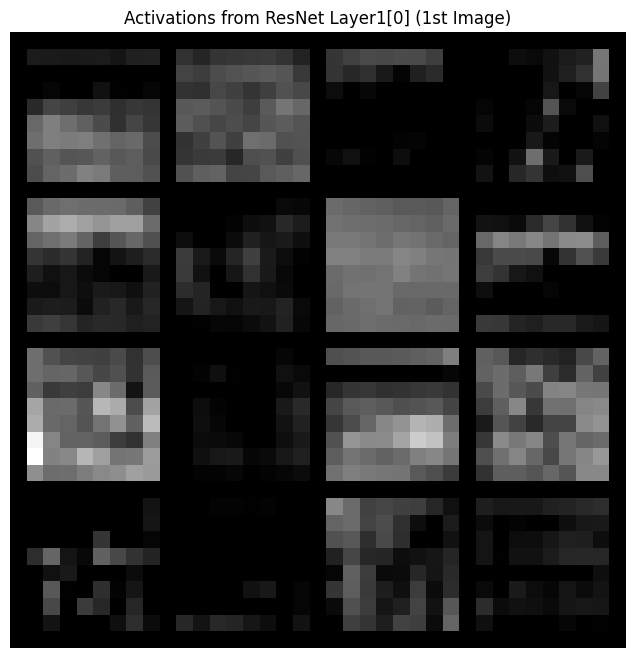

In [ ]:
# %%

# Visualize Activations of Intermediate Layers
# Hook into a middle layer like layer1[0]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook
pretrained_resnet.layer1[0].register_forward_hook(get_activation('layer1_block0'))

# Run a batch through the model
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images.to(device)
_ = pretrained_resnet(images)

# Show activations (first image, first 16 channels)
act = activation['layer1_block0'][0, :16]  # shape: (C,H,W)

grid = make_grid(act.unsqueeze(1), nrow=4, normalize=True, padding=1)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Activations from ResNet Layer1[0] (1st Image)")
plt.show()